## PUBG Stats report generator

Generates a lifetime (since January 2018) stats report for each game mode (per round where applicable), and a summary of KD ratios across all modes

In [1]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
import os
import shutil
import time

In [8]:
cwd = os.getcwd()     

players = ['simonr0204', '01zaporozhets', 'dragman', 'Marky_Boi', 'Jaideka', 'Lt-GobelCoque']      #Players to compare       


destination = os.path.join(cwd, '-'.join(players)) 
if not os.path.exists(destination):
    os.makedirs(destination)
else:
    shutil.rmtree(destination)           
    os.makedirs(destination) 

In [9]:
def get_data(players):

    with open('API_KEY.txt', 'r') as keyfile:
        api_key = keyfile.read()                                           #Your API key goes here
                                         

    def getID(playername):                                          #Gets the player ID associated with each player name. Seems like this 2nd call to API could be avoided

        url = "https://api.pubg.com/shards/steam/players?filter[playerNames]="+playername          
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }

        IDdata = requests.get(url, headers=header).json()
        return (IDdata['data'][0]['id'])
       
    jsons=[]
    IDS = []
    
    if len(players)<6:
        wait_time = 0
    else:
        wait_time = 6.1 #limit is 10 requests per minute, so 6 seconds per requestt
    
    for player in players:
        IDS.append(getID(player))
        time.sleep(wait_time)
    
    for ID in IDS:                                                #Gets the lifetime (post jan-2018) history of each player ID
        url = f'https://api.pubg.com/shards/steam/players/{ID}/seasons/lifetime'          
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }
        response = requests.get(url, headers=header).json()
        jsons.append(response)
        time.sleep(wait_time)

   
    #Concatenate and tidy up the data
    all_data = pd.concat([pd.DataFrame(jsons[i]['data']['attributes']['gameModeStats']) for i,_ in enumerate(players)], axis=1, keys = players)
    all_data = all_data.transpose()
    all_data.fillna(0, inplace=True)
    all_data = all_data[all_data['roundsPlayed']!=0]
    all_data.drop('rankPointsTitle', axis=1, inplace=True)
    all_data.to_excel('-'.join(players)+'.xls')      #save to excel file
    shutil.move('-'.join(players)+'.xls', destination)
    return all_data

In [10]:
data = get_data(players)

In [11]:
#Convert relevant data to per round basis:

for col in ['assists', 'boosts', 'dBNOs', 'damageDealt', 'headshotKills', 'heals',
       'kills', 'losses', 'revives', 'rideDistance', 'roadKills', 'suicides', 'swimDistance', 'teamKills', 
        'timeSurvived', 'top10s', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'wins']:
    
    data[col] = data[col] / data['roundsPlayed']
data

assists  bestRankPoint    boosts     dBNOs  \
simonr0204    duo-fpp    0.201869     1956.47020  0.639252  0.657944   
              solo-fpp   0.050000     1762.11010  0.825000  0.000000   
              squad-fpp  0.320513     1266.08920  0.884615  1.089744   
01zaporozhets duo-fpp    0.129944     1727.17220  0.789077  0.519774   
              solo-fpp   0.000000        0.00000  0.000000  0.000000   
              squad-fpp  0.440000     1114.44900  1.020000  0.940000   
dragman       duo-fpp    0.227273     1024.59190  0.681818  0.636364   
              squad-fpp  0.404959     1309.79280  1.049587  0.909091   
Marky_Boi     duo-fpp    0.301587     1008.48425  0.714286  0.634921   
              solo-fpp   0.048780     1153.83340  0.609756  0.000000   
              squad-fpp  0.481481     1119.10050  1.240741  1.000000   
Jaideka       duo-fpp    0.133333      976.58575  0.800000  0.266667   
              squad-fpp  0.473684     1108.77980  0.710526  0.421053   

                         dailyKills  dailyWins  damageDealt  days  \
simonr0204    duo-fpp             1          0   141.113626    55   
              solo-fpp            0          0   161.363892    13   
              squad-fpp          20          0   166.685910    12   
01zaporozhets duo-fpp             1          0    98.441111    52   
              solo-fpp            0          0    50.000000     2   
              squad-fpp          15          0   131.561494     9   
dragman       duo-fpp             1          0   134.398341     8   
              squad-fpp          12          0   145.515686    20   
Marky_Boi     duo-fpp             1          0   138.648095    10   
              solo-fpp            6          0   129.623917    14   
              squad-fpp           3          0   174.546222    12   
Jaideka       duo-fpp             1          0    61.551433     3   
              squad-fpp           4          0    64.112079     6   

                         headshotKills     heals    ...     teamKills  \
simonr0204    duo-fpp         0.302804  1.310280    ...      0.014953   
              solo-fpp        0.425000  1.025000    ...      0.000000   
              squad-fpp       0.282051  1.115385    ...      0.038462   
01zaporozhets duo-fpp         0.129944  1.996234    ...      0.022599   
              solo-fpp        0.000000  0.000000    ...      0.000000   
              squad-fpp       0.240000  2.580000    ...      0.060000   
dragman       duo-fpp         0.227273  1.136364    ...      0.022727   
              squad-fpp       0.198347  1.264463    ...      0.049587   
Marky_Boi     duo-fpp         0.222222  1.523810    ...      0.015873   
              solo-fpp        0.243902  0.707317    ...      0.048780   
              squad-fpp       0.203704  2.037037    ...      0.074074   
Jaideka       duo-fpp         0.000000  1.466667    ...      0.066667   
              squad-fpp       0.105263  2.342105    ...      0.026316   

                         timeSurvived    top10s  vehicleDestroys  \
simonr0204    duo-fpp      533.664262  0.157009         0.003738   
              solo-fpp     527.320700  0.100000         0.000000   
              squad-fpp    661.119872  0.294872         0.000000   
01zaporozhets duo-fpp      509.795782  0.148776         0.005650   
              solo-fpp     322.022500  0.000000         0.000000   
              squad-fpp    682.671960  0.320000         0.020000   
dragman       duo-fpp      663.143295  0.159091         0.000000   
              squad-fpp    755.000132  0.297521         0.016529   
Marky_Boi     duo-fpp      666.886508  0.158730         0.000000   
              solo-fpp     534.655829  0.073171         0.000000   
              squad-fpp    828.943333  0.277778         0.000000   
Jaideka       duo-fpp      519.990753  0.133333         0.000000   
              squad-fpp    721.287842  0.263158         0.000000   

                         walkDistance  weaponsAcquired  weeklyKills  \
sim

In [6]:
#Generate plots for each mode, each with comparisons of the players over all attributes (except attributes specified to drop)
def generate_plots(data, plots_to_drop):                           
  
    data = data.drop(plots_to_drop, axis=1)                                           

    for m in modes:                                                    
        fig = plt.figure(figsize=(40,35), dpi=100)
        fig.suptitle('PUBG Lifetime (since Jan. 2018) stats per round (where applicable) \n'+'-'.join(players)+'\n'+m, fontsize=40)  
        print(f'Comparing players in mode {m}')
        for i,col in enumerate(data.columns):
            fig.add_subplot(4, 8, i+1, xmargin=0.5, ymargin=0.5)
            fig.subplots_adjust(wspace=0.5, hspace=0.5)
            data.xs(m, level=1)[col].plot(kind='bar', title=col)
            fig.savefig(destination+'\\'+m)                         #Save figure to file

Comparing players in mode solo-fpp
Comparing players in mode duo-fpp
Comparing players in mode squad-fpp


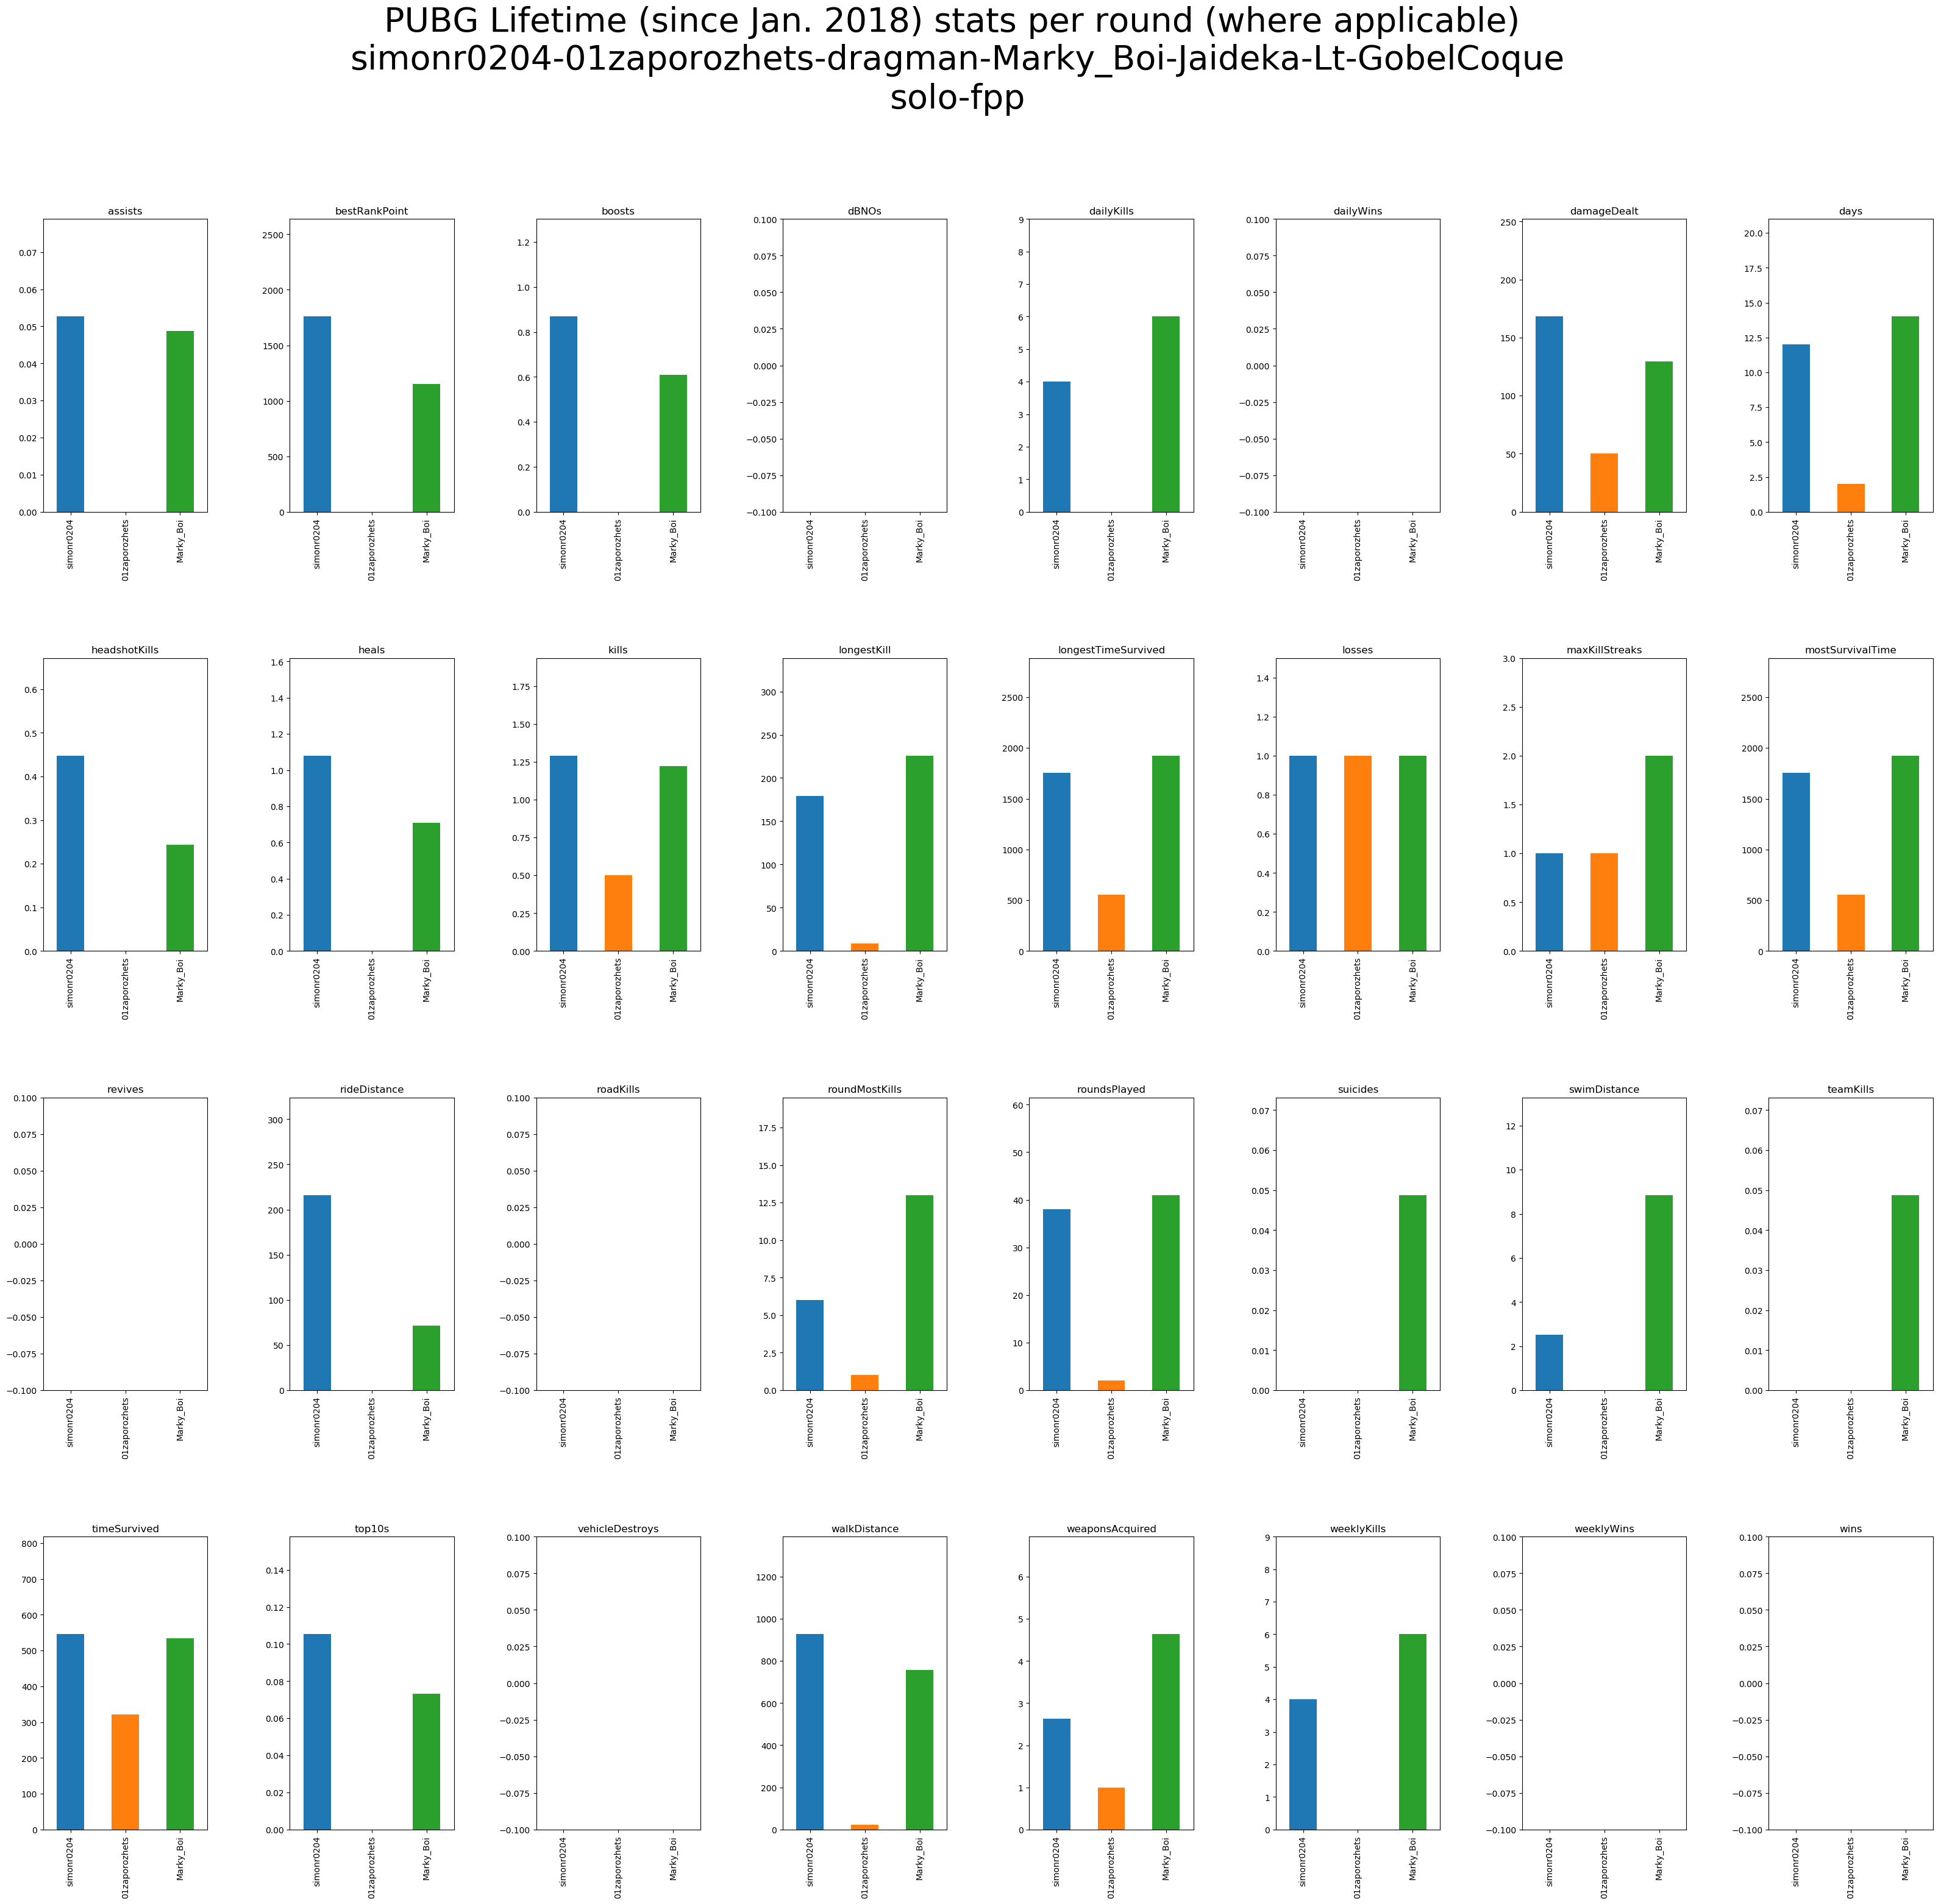

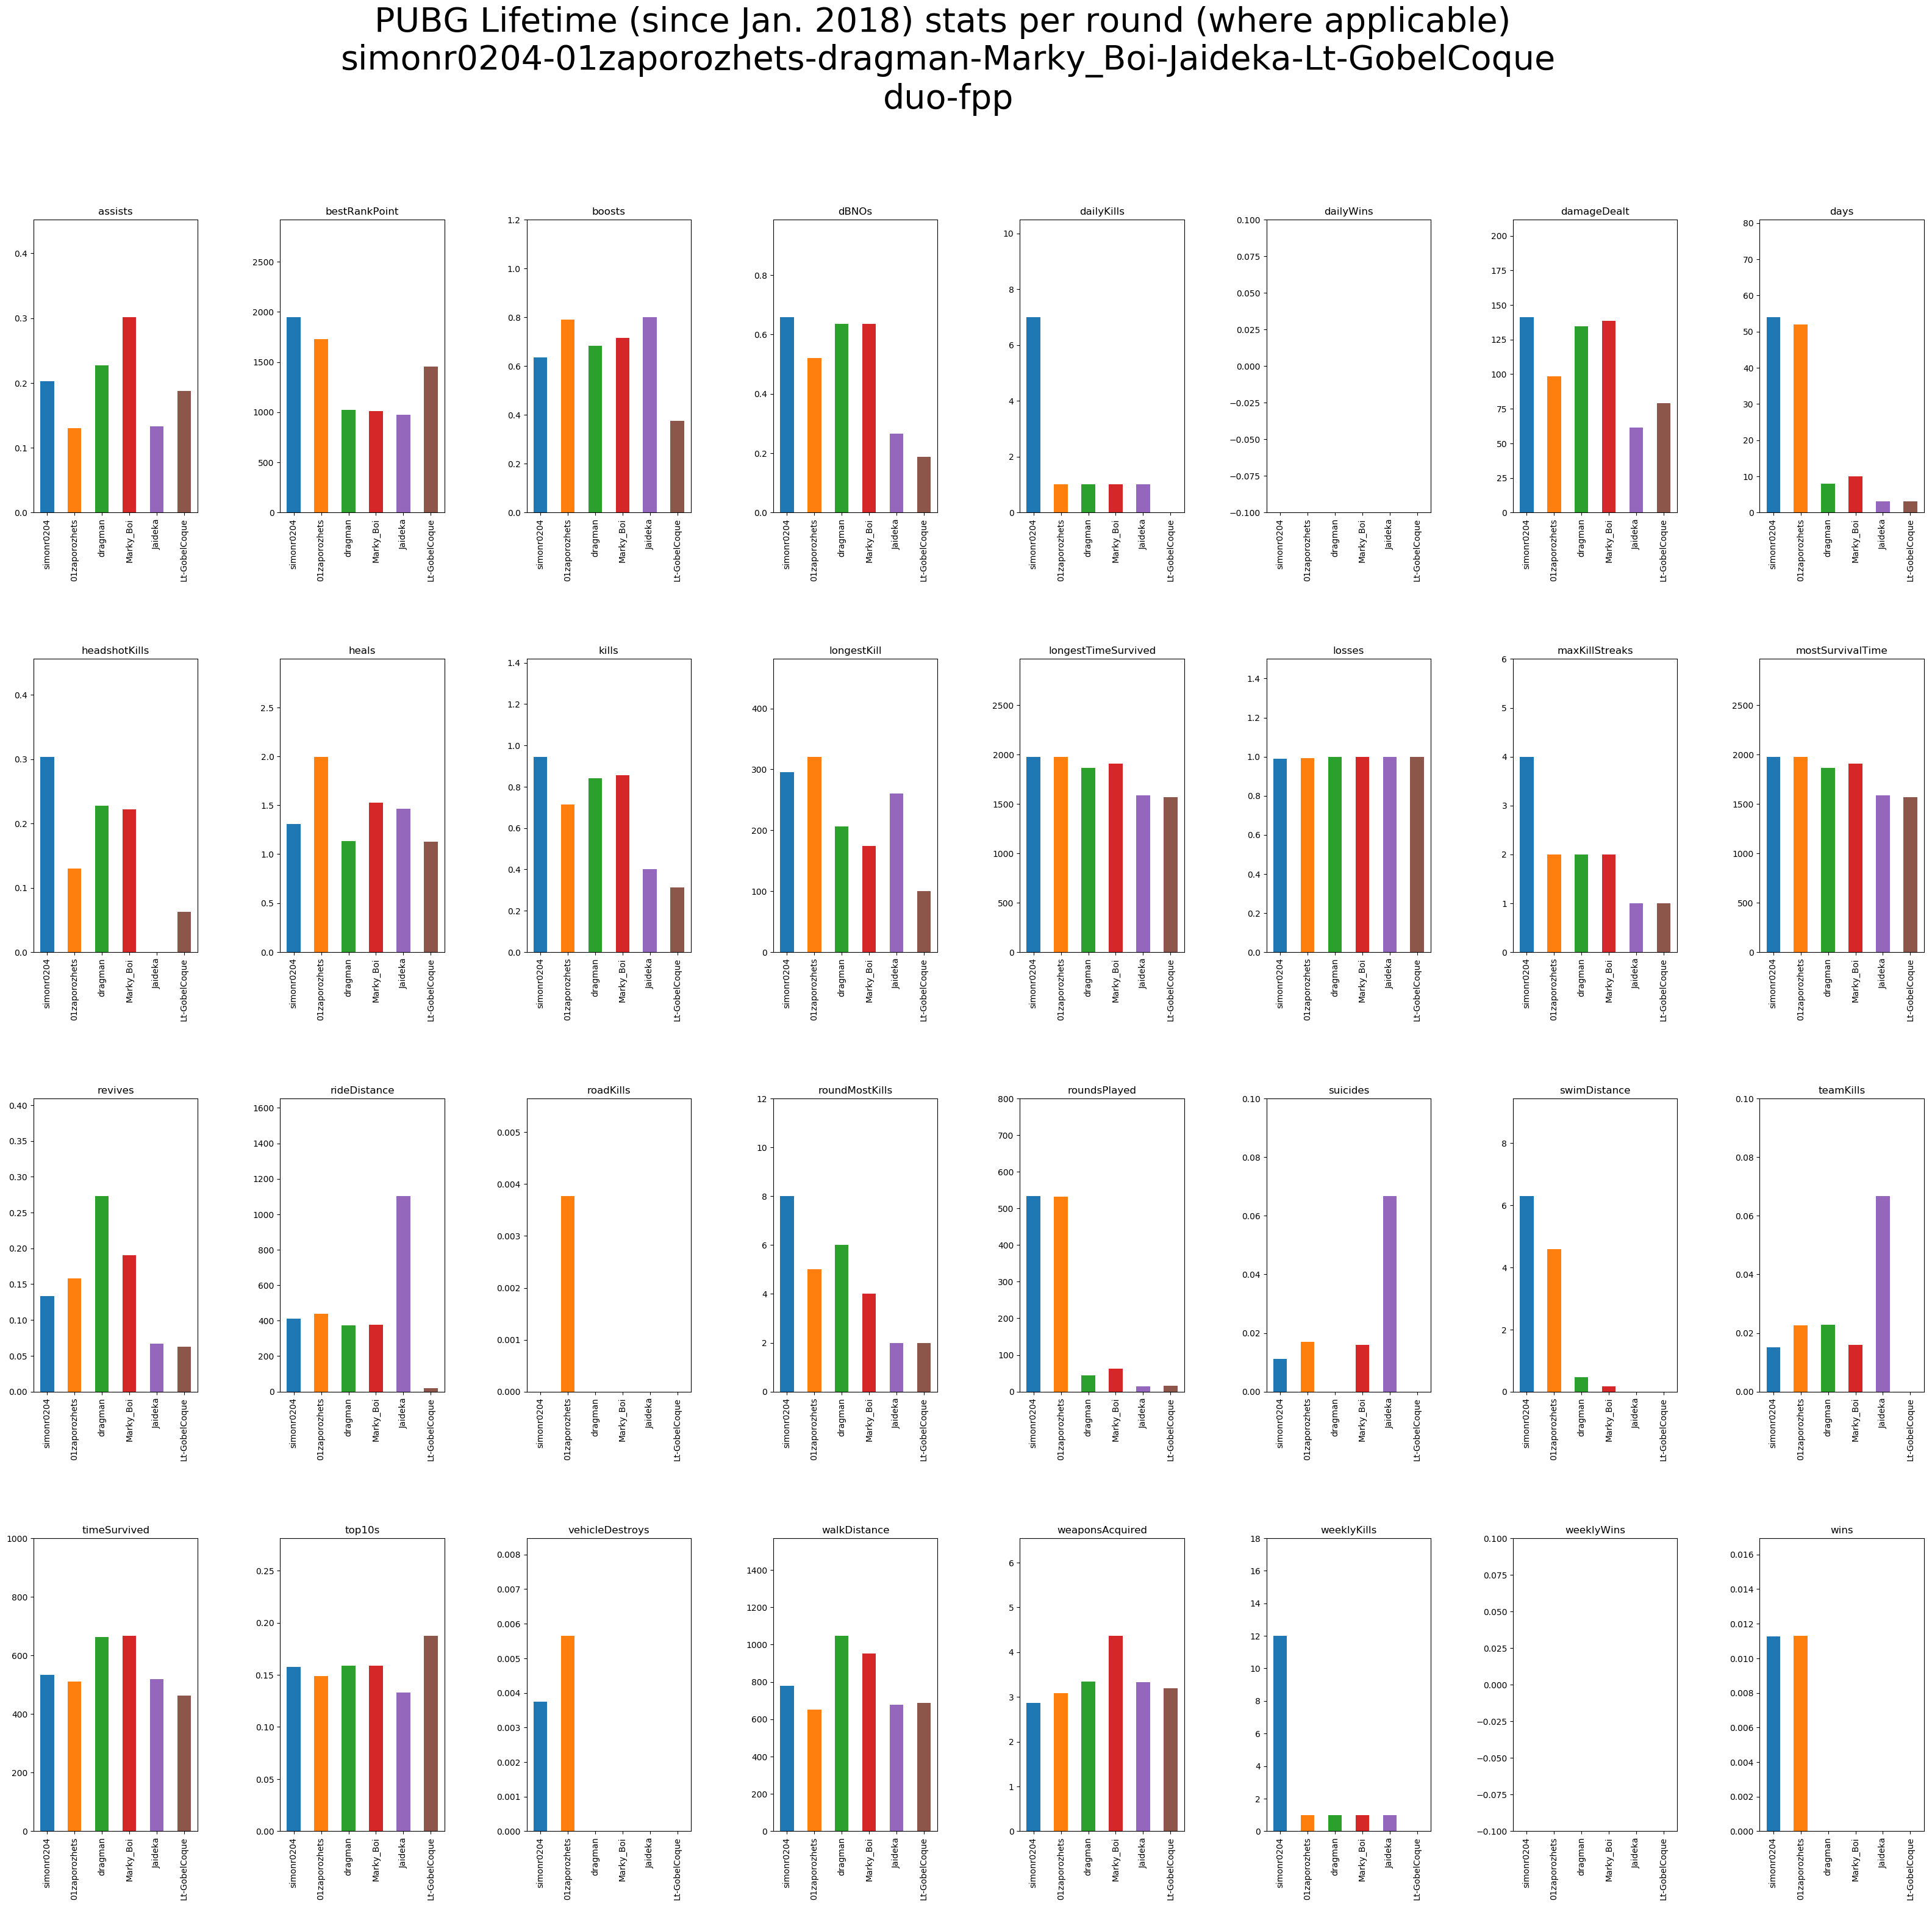

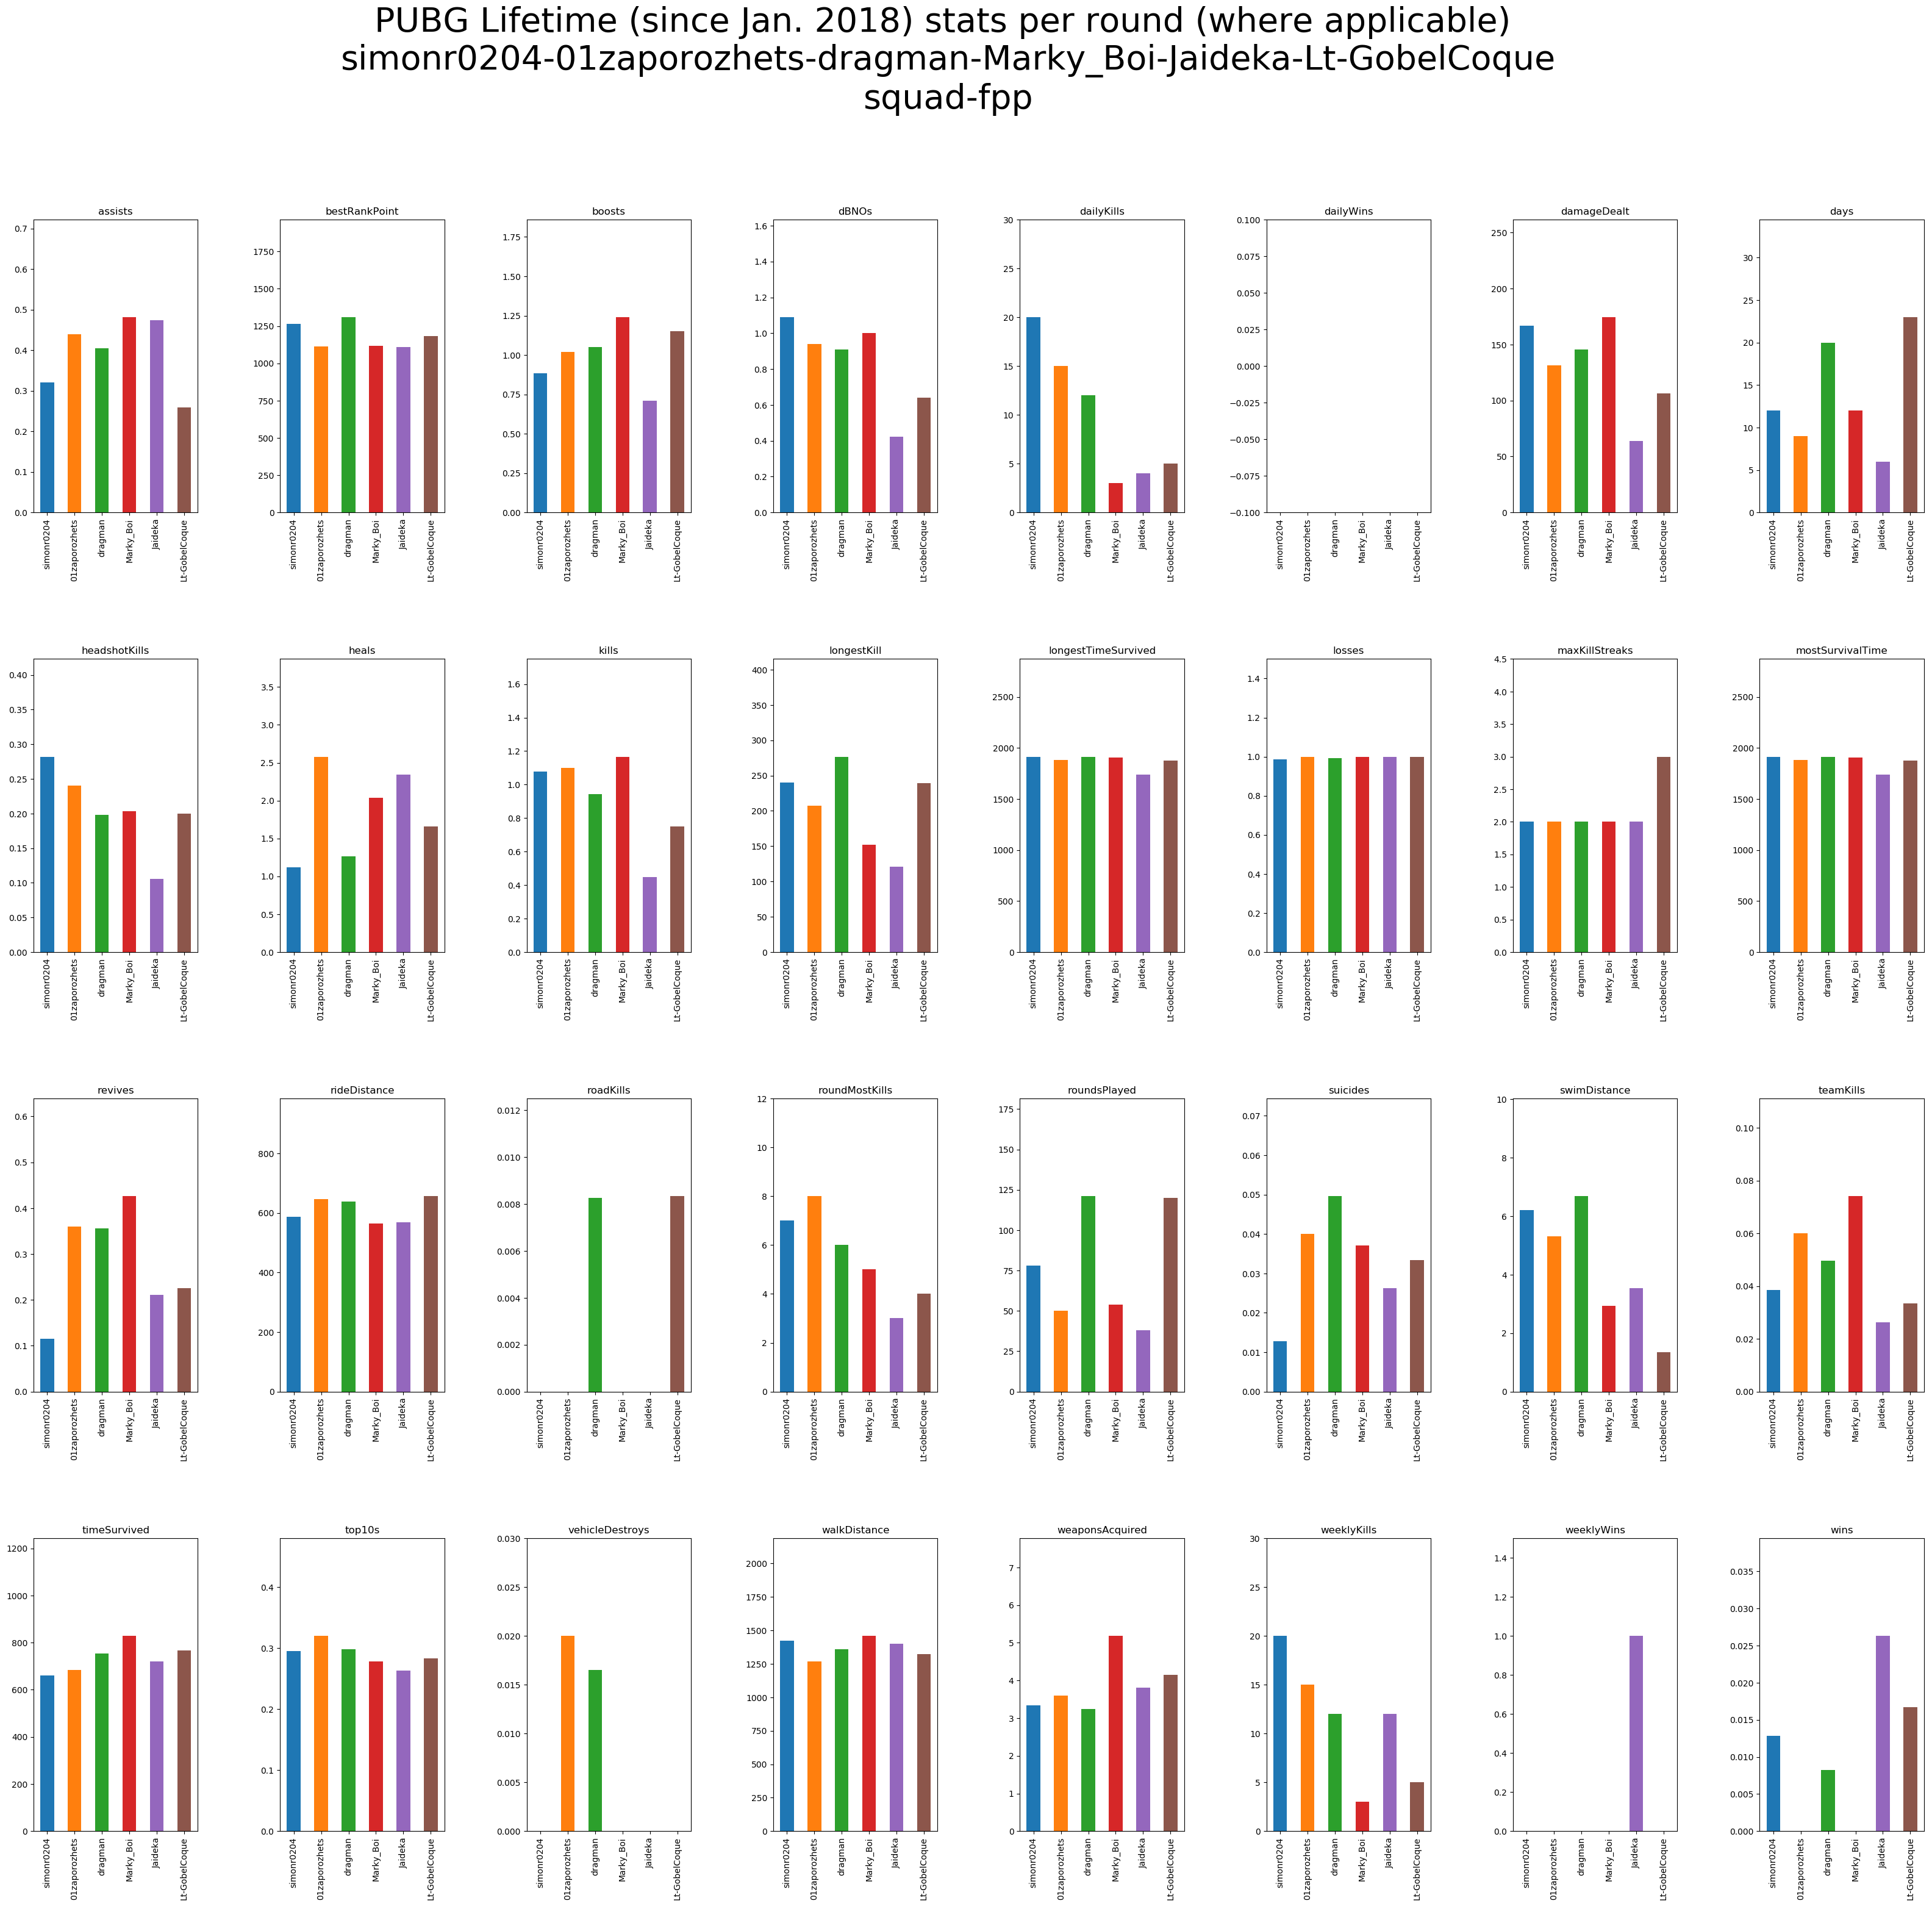

In [7]:
modes = ['solo-fpp', 'duo-fpp' , 'squad-fpp']                 #Modes to draw plots for (one file per mode. Option are: solo/duo/squad  - fpp/tpp)
plots_to_drop = ['rankPoints','killPoints','winPoints']  #Attributes not to include in figures

generate_plots(data, plots_to_drop)

In [8]:
#Plot the KD ratio of each player in each mode
def plot_kd_ratio(data):
    
    data['KD'] = data['kills']/data['losses']
    fig, axes = plt.subplots(nrows=1, ncols=len(modes), figsize=(10,6))
    fig.suptitle(f'PUBG Lifetime (since Jan. 2018) KD ratio \n'+'-'.join(players))
    i=0
    for m in modes:
        axis=axes[i]
        axis.set_title(m)
        plt.subplots_adjust(top=0.85)
        data.xs(m, level=1)['KD'].plot(kind='bar', ax=axis)     
        i+=1
    fig.savefig(f'{destination}\\KD_ratios')

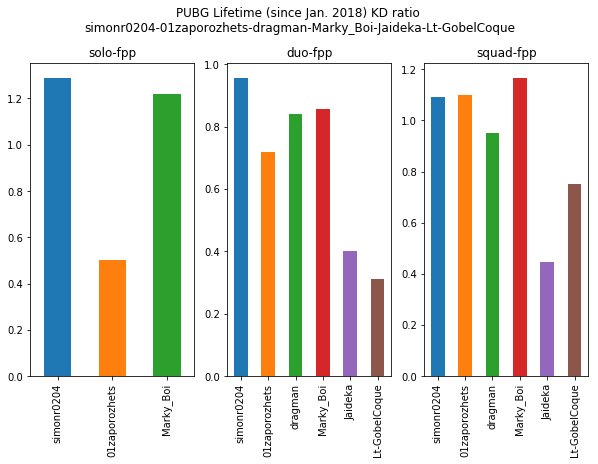

In [9]:
plot_kd_ratio(data)